<a id="1"></a>
# <div style="padding: 20px; color: cyan; margin: 0; font-size: 30px; font-family: Arial; text-align: left; border-radius: 5px; background-color: #000000; border: 2px solid blue;"><b>Preprocessing</b></div>

<a id="1.2"></a>
<h2 style=" font-family: Arial; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #00CC99; padding: 15px;  border-bottom: 2px solid blue;
"><b>Import</b> libraries

In [38]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

print("Setup Complete!")

Setup Complete!


<a id="1.2"></a>
<h2 style=" font-family: Arial; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #00CC99; padding: 15px;  border-bottom: 2px solid blue;
"><b>Exploring</b> data

> <span style='font-size:15px; font-family:Arial; color: #87CEFA;'><b>
Read raw data </b></span>

In [39]:
def is_path_exists(path):
    if not os.path.exists(path):
        return False
    return True

In [40]:
path = '../data/raw/raw_data.csv'
if is_path_exists(path):
    raw_df = pd.read_csv(path)
else:
    print("File not found!")

> <span style='font-size:15px; font-family:Arial; color: #87CEFA;'><b>
What are the dimensions of the raw data? </b></span>

In [41]:
# Get number of rows and columns in the data set
print(f"Data shape: {raw_df.shape}")
print(f"Rows = {raw_df.shape[0]} | Columns = {raw_df.shape[1]}")

Data shape: (5952, 20)
Rows = 5952 | Columns = 20


In [42]:
raw_df.head(2)

,name,description,designer,artist,publisher,min_players,max_players,min_playtime,max_playtime,playing_time,min_age,complexity_rating,user_ratings,user_comments,type,category,mechanism,family,year,average_rating
0,Samurai,Dispute the favor of three different castes in...,Reiner Knizia,Franz Vohwinkel,"Fantasy Flight Games, Hans im Glück + 15 more",2.0,4.0,30.0,60.0,45.0,10.0,2.47,16000,4000,Strategy,"Abstract Strategy, Medieval","Area Majority / Influence, Hand Management, He...",Components: Map (Continental / National scale)...,1998.0,7.5
1,Die Macher,Players represent political parties attempting...,Karl-Heinz Schmiel,"Bernd Brunnhofer, Marcus Gschwendtner, Harald ...","Hans im Glück, Moskito Spiele + 7 more",3.0,5.0,240.0,240.0,240.0,14.0,4.31,5700,2100,Strategy,"Economic, Negotiation, Political","Alliances, Area Majority / Influence, Auction/...","Country: Germany, Digital Implementations: VAS...",1986.0,7.6


> <span style='font-size:15px; font-family:Arial; color: #87CEFA;'><b>
Are there duplicates in the raw data? </b></span>

In [43]:
def is_duplicated_rows(df):
    '''
    Check if there are duplicated rows in the dataframe
    params: df: dataframe
    return: True if there are duplicated rows, False otherwise
    '''
    index = df.index
    detect_dup_series = index.duplicated(keep='first')
    num_duplicated_rows = detect_dup_series.sum()
    return True if num_duplicated_rows > 0 else False

In [44]:
# If there are duplicated rows, drop them
if is_duplicated_rows(raw_df):
    raw_df = raw_df.drop_duplicates(keep='first')
    print('Shape after de-deduplicate: ', raw_df.shape)
else:
    print('No duplicated row.')

No duplicated row.


> <span style='font-size:15px; font-family:Arial; color: #87CEFA;'><b>
Are any data types incompatible with further analysis?</b></span>

In [45]:
def find_data_type(df):
    cat_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
    num_cols = df.select_dtypes(exclude=['object', 'bool']).columns.tolist()
    
    return cat_cols, num_cols

In [46]:
cat_cols, num_cols = find_data_type(raw_df)
print(f"Categorical columns: {cat_cols}")
print(f"Numerical columns: {num_cols}")

Categorical columns: ['name', 'description', 'designer', 'artist', 'publisher', 'type', 'category', 'mechanism', 'family']
Numerical columns: ['min_players', 'max_players', 'min_playtime', 'max_playtime', 'playing_time', 'min_age', 'complexity_rating', 'user_ratings', 'user_comments', 'year', 'average_rating']


In [47]:
# Raw data state
dtype = raw_df.dtypes
dtype

name                  object
description           object
designer              object
artist                object
publisher             object
min_players          float64
max_players          float64
min_playtime         float64
max_playtime         float64
playing_time         float64
min_age              float64
complexity_rating    float64
user_ratings           int64
user_comments          int64
type                  object
category              object
mechanism             object
family                object
year                 float64
average_rating       float64
dtype: object

<div style="font-size:14px; font-family:Verdana; border-radius:10px; border: #4E5672 solid; padding: 15px; background-color: #CCFFCC; text-align:left; color: #4E5672">


<h3 align="left"><font color='#4E5672'>💡 Comment:</font></h3>

* **Data Type Recommendations:**
  
  * float64 --> int64: **`min_players`, `max_players`, `min_playtime`, `max_playtime`, `playing_time`, `min_age`**
  
  * float64 --> int32: **`year`**
  
* These columns represent whole numbers and storing them as float64 incurs unnecessary memory usage and potential precision issues. Converting them to int64 will optimize storage and increase processing efficiency during analysis.

</div>

> <span style='font-size:15px; font-family:Arial; color: #87CEFA;'><b>
What are the distribution characteristics of each numeric data column?</b></span>

In [48]:
# Statistics of numerical columns

def missing_ratio(s):
    return (s.isna().mean() * 100).round(3)

def median(df):
    return (df.quantile(0.5)).round(1)

def lower_quartile(df):
    return (df.quantile(0.25)).round(1)

def upper_quartile(df):
    return (df.quantile(0.75)).round(1)

In [49]:
numeric_info = raw_df.select_dtypes(exclude=['object', 'bool'])
# Get missing ratio and five number summary of each numerical column
numeric_info = numeric_info.agg([missing_ratio, "min", lower_quartile, median, upper_quartile, "max"])
numeric_info

,min_players,max_players,min_playtime,max_playtime,playing_time,min_age,complexity_rating,user_ratings,user_comments,year,average_rating
missing_ratio,1.596,1.596,16.482,16.482,16.482,15.877,44.036,0.0,0.0,5.376,0.0
min,1.000,1.000,1.000,1.000,1.000,2.000,1.000,1.0,0.0,1000.000,1.0
lower_quartile,2.000,4.000,20.000,30.000,22.500,8.000,1.200,3.0,1.0,1999.000,5.6
median,2.000,4.000,30.000,45.000,40.000,10.000,2.000,10.0,5.0,2012.000,6.5
upper_quartile,2.000,6.000,60.000,90.000,75.000,12.000,2.600,59.0,26.0,2018.000,7.4
max,40.000,600.000,1500.000,12000.000,6060.000,30.000,5.000,123000.0,21000.0,2024.000,10.0


In [50]:
# Get missing columns in numerical columns
missing_num_cols = numeric_info.loc['missing_ratio', numeric_info.loc['missing_ratio'] > 0].index.tolist()
print(f"Missing columns: {missing_num_cols}")

Missing columns: ['min_players', 'max_players', 'min_playtime', 'max_playtime', 'playing_time', 'min_age', 'complexity_rating', 'year']


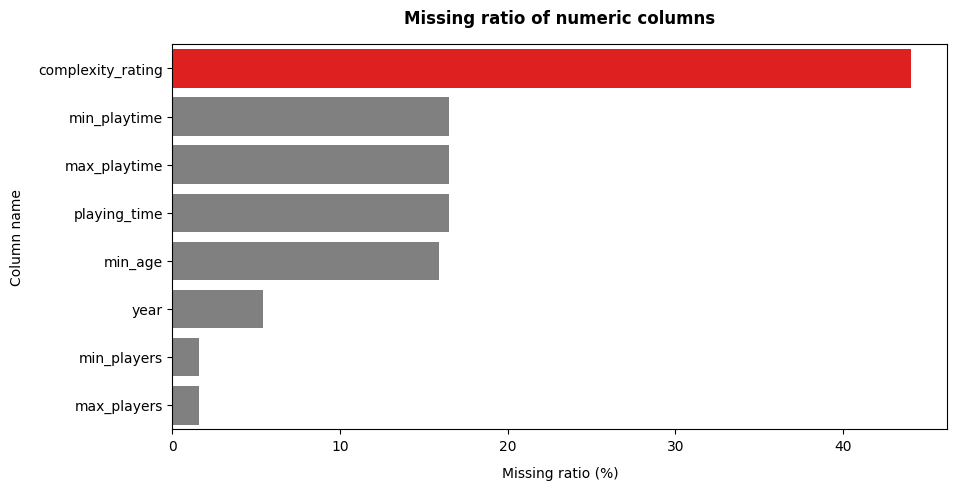

In [51]:
df = numeric_info.loc['missing_ratio', numeric_info.loc['missing_ratio'] > 0].reset_index().sort_values(by='missing_ratio', ascending=False)

# Create a color list, with 'red' for the highest value and 'grey' for the rest
colors = ['red' if x == df['missing_ratio'].max() else 'grey' for x in df['missing_ratio']]

fig = plt.figure(figsize=(10, 5))
sns.barplot(y='index', x='missing_ratio', data=df, palette=colors)

plt.title('Missing ratio of numeric columns', fontsize=12, pad=15, weight='bold')
plt.ylabel('Column name', fontsize=10, labelpad=10)
plt.xlabel('Missing ratio (%)', fontsize=10, labelpad=10)

plt.show()

<div style="font-size:14px; font-family:Verdana; border-radius:10px; border: #4E5672 solid; padding: 15px; background-color: #CCFFCC; text-align:left; color: #4E5672">


<h3 align="left"><font color='#4E5672'>💡 Comment:</font></h3>

* **Missing Values:**

  * The complexity rating column exhibits a significantly higher missing value ratio compared to other columns, particularly the time and age columns.

  * Notably, its missing ratio is several times higher than the remaining columns. 
  
  * This disparity warrants further investigation to understand the underlying reasons for missing data and assess its potential impact on the analysis.

* **Outliers:**

  * Five-number summaries of the players, time, ratings, comments, and year columns reveal potentially significant outliers. In the players and time columns, the maximum value is considerably larger than the median, suggesting the presence of data points that deviate significantly from the central tendency. 

  * Similarly, the year column exhibits a minimum value significantly lower than the median, indicating potential noise or anomalies in the data. These outliers require careful evaluation and handling to ensure accurate and reliable analysis results.
  
</div>

> <span style='font-size:15px; font-family:Arial; color: #87CEFA;'><b>
What are the distribution characteristics of each non-numeric data column?</b></span>

In [52]:
# Statistics of categorical columns
def num_values(s):
    s = s.astype(str).str.split(',')
    s = s.explode()
    return len(s.value_counts())

def value_ratios(s):
    s = s.astype(str).str.split(',')
    s = s.explode()
    totalCount = (~s.isna()).sum()
    return ((s.value_counts()/totalCount*100).round(1)).to_dict()

In [53]:
category_info = raw_df.select_dtypes(include=['object', 'bool'])
category_info = category_info.agg([missing_ratio, num_values, value_ratios])
category_info

,name,description,designer,artist,publisher,type,category,mechanism,family
missing_ratio,5.376,0.0,14.499,48.387,0.067,0.0,1.193,12.735,24.261
num_values,5754,2429,3745,3068,3378,15,175,321,2703
value_ratios,"{'nan': 5.2, 'Warhammer 40': 0.1, 'UltraQuest:...","{'Add a Brief Description': 61.7, 'Win the fav...","{'nan': 11.7, '(Uncredited)': 8.7, 'Reiner Kni...","{'nan': 38.3, '(Uncredited)': 2.3, 'Franz Vohw...","{'(Self-Published)': 3.9, '(Web published)': 3...","{'Uncategorized': 70.2, 'Wargames': 8.5, 'Abst...","{'Card Game': 7.2, 'Expansion for Base-game': ...","{'Dice Rolling': 6.4, 'nan': 5.0, ' Dice Rolli...","{'nan': 11.7, ' Players: Two Player Only Games..."


In [54]:
missing_cat_cols = category_info.loc['missing_ratio', category_info.loc['missing_ratio'] > 0].index.tolist()
print(f"Missing columns: {missing_cat_cols}")

Missing columns: ['name', 'designer', 'artist', 'publisher', 'category', 'mechanism', 'family']


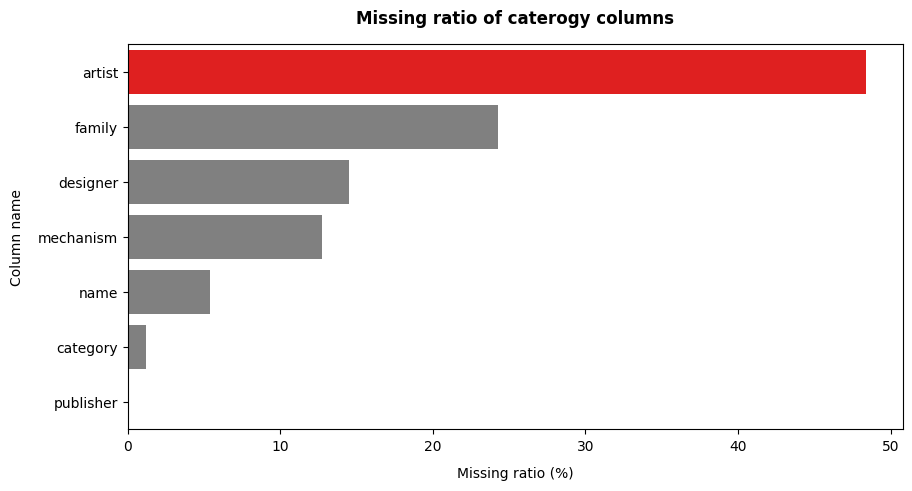

In [55]:
df = category_info.loc['missing_ratio', category_info.loc['missing_ratio'] > 0].reset_index().sort_values(by='missing_ratio', ascending=False)

# Create a color list, with 'red' for the highest value and 'grey' for the rest
colors = ['red' if x == df['missing_ratio'].max() else 'grey' for x in df['missing_ratio']]

fig = plt.figure(figsize=(10, 5))
sns.barplot(y='index', x='missing_ratio', data=df, palette=colors)
plt.title('Missing ratio of caterogy columns', fontsize=12, pad=15, weight='bold')
plt.ylabel('Column name', fontsize=10, labelpad=10)
plt.xlabel('Missing ratio (%)', fontsize=10, labelpad=10)

plt.show()

<div style="font-size:14px; font-family:Verdana; border-radius:10px; border: #4E5672 solid; padding: 15px; background-color: #CCFFCC; text-align:left; color: #4E5672">


<h3 align="left"><font color='#4E5672'>💡 Comment:</font></h3>

* **Missing Values:**
  
  * The **`artist`** column exhibits the highest missing value ratio among all categorical features, with a value double that of the next highest. 

  * This warrants further investigation to understand the underlying reason for missing data and assess its potential impact on the analysis.

* **Value Composition and Imputation:**
  
  * The **`designer`** and **`artist`** columns exhibit two distinct values: "nan" and "uncredited," accompanied by the **`description`** "add a brief description." This suggests that some missing values may be attributed to the need for additional information. 
  
  * Careful consideration should be given when imputing missing values in these columns, potentially utilizing the provided description to guide the process.

* **Data Formatting:**
  
  * The **`type`**, **`category`**, and **`mechanism`** columns appear to contain lists of values. Converting these columns to list format and "exploding" them would result in a more structured and analyzable representation of the data. This will facilitate more efficient data manipulation and analysis techniques.
</div>

<a id="1.2"></a>
<h2 style=" font-family: Arial; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #00CC99; padding: 15px;  border-bottom: 2px solid blue;
"><b>Cleaning </b> data

<div style="font-size:14px; font-family:Verdana; border-radius:10px; border: #4E5672 solid; padding: 15px; background-color: #CCFFCC; text-align:left; color: #4E5672">


<h3 align="left"><font color='#4E5672'>💡 Comment:</font></h3>

* Addressing features with significant missing values to avoid to present challenges for effective analysis and are typically excluded from the dataset.

* The threshold for defining "significant" missingness can be adjusted based on specific goals. Generally, features exceeding a 75% missing value ratio are removed, resulting in a refined and more manageable dataset. This approach ensures that the analysis focuses on features with sufficient data for meaningful insights.
  
</div>

In [56]:
def drop_missing_features(df, missing_lst, threshold) -> pd.DataFrame:
    """Drop missing features from Pandas dataframe base on given threshold.

    Args:
        df (pd.DataFrame): Input dataframe for processing.
        missing_lst (dict, optional): Dict missing value rate which calculated from previous stage.
        threshold (float, optional): User threshold for dropping. (%)

    Returns:
        pd.DataFrame: Updated dataframe
    """
    if (df is None) or (missing_lst is None) or (threshold is None):
        print(f"[LOG] Invalid.")
        raise ValueError
    
    # Create a copy of the dataframe to avoid changing the original
    df_cp = df.copy()
    
    # List to maintain the columns to drop
    cols_to_trim = []
    
    for key, value in missing_lst.items():
        if float(value) > threshold:
            cols_to_trim.append(key)
            
    if len(cols_to_trim) > 0:
        # drop the columns identified using the dataframe drop() method
        df_cp = df_cp.drop(columns=cols_to_trim)
        print("[LOG] Dropped column(s): " + ", ".join(cols_to_trim))
    else:
        print("[LOG] Have no column(s) to trim.")
        
    return df_cp

In [57]:
# Drop columns with missing ratio > 50%
raw_df = drop_missing_features(raw_df, dict(numeric_info.iloc[0]), 50.0)

[LOG] Have no column(s) to trim.


<div style="font-size:14px; font-family:Verdana; border-radius:10px; border: #4E5672 solid; padding: 15px; background-color: #CCFFCC; text-align:left; color: #4E5672">


<h3 align="left"><font color='#4E5672'>💡 Comment:</font></h3>

* Despite eliminating features with a substantial number of missing values, missing values persist in our dataframe. Consequently, we must impute these missing values to render the data suitable for analysis.
  
</div>


In [58]:
print('missing_num_cols: ', missing_num_cols)
print('missing_cat_cols: ', missing_cat_cols)

missing_num_cols:  ['min_players', 'max_players', 'min_playtime', 'max_playtime', 'playing_time', 'min_age', 'complexity_rating', 'year']
missing_cat_cols:  ['name', 'designer', 'artist', 'publisher', 'category', 'mechanism', 'family']


In [59]:
# Filling missing values for numeric columns
missing_num_cols.remove('playing_time')
missing_num_cols.remove('complexity_rating')

for col in missing_num_cols:
    raw_df[col] = raw_df[col].fillna(raw_df[col].median())
 
raw_df['playing_time'] = (raw_df['min_playtime'] + raw_df['max_playtime']) / 2
raw_df['complexity_rating'] = raw_df['complexity_rating'].fillna(1.0)

# Filling missing values for categorical columns
missing_cat_cols.remove('designer')
missing_cat_cols.remove('artist')

for col in missing_cat_cols:
    raw_df[col] = raw_df[col].fillna('Unknown')

raw_df['description'] = raw_df['description'].replace('Add a Brief Description', 'Unknown')
raw_df[['designer', 'artist']] = raw_df[['designer', 'artist']].fillna('Uncredited')

In [60]:
raw_df.agg([missing_ratio]).T.reset_index().rename(columns={'index': 'column_name', 0: 'missing_ratio'})

,column_name,missing_ratio
0,name,0.0
1,description,0.0
2,designer,0.0
3,artist,0.0
4,publisher,0.0
5,min_players,0.0
6,max_players,0.0
7,min_playtime,0.0
8,max_playtime,0.0
9,playing_time,0.0


<a id="1.2"></a>
<h2 style=" font-family: Arial; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #00CC99; padding: 15px;  border-bottom: 2px solid blue;
"><b>Detecting </b> Outliers

In [61]:
def outlier_detector(df, cols, take_care_outliners=False, print_outliners=False, q_1=0.25, q_3=0.75):
    '''
    Detect outliers in the dataframe by trimming method
    Args:
        df: dataframe
        cols: list of columns to detect outliers
        take_care_outliners: if True, remove outliers from the dataframe
        print_outliners: if True, print outliners
        q_1: lower quartile
        q_3: upper quartile
    Return:
        temp: dataframe contains outliers information
        data: dataframe after removing outliers
    '''
    temp = pd.DataFrame()
    data = df.copy()
    for col in cols:
        Q1 = data[col].quantile(q_1)
        Q3 = data[col].quantile(q_3)
        IQR = Q3 - Q1
        upper = Q3 + 1.5 * IQR
        lower = Q1 - 1.5 * IQR
        
        temp.loc[col, "Min"] = round(data[col].min())
        temp.loc[col, "Low_Limit"] = round(lower)
        temp.loc[col, "Mean"] = round(data[col].mean())
        temp.loc[col, "Median"] = round(data[col].median())
        temp.loc[col,"Up_Limit"] = round(upper)
        temp.loc[col, "Max"] = data[col].max()        
        temp.loc[col, "Outlier"] = "Min-Max" if (data[col].max() > upper) & (lower > data[col].min())\
                                    else ("Max" if data[col].max() > upper \
                                    else ("Min" if lower > data[col].min() \
                                    else "No"))
        temp.loc[col, 'Number of Outliers'] = data.loc[(data[col] > upper) | (data[col] < lower)].shape[0]
        
        if take_care_outliners:
            data = data[(data[col] <= upper) & (data[col] >= lower)]
            # data.loc[data[col] > upper, col] = round(upper - 1)
            # data.loc[data[col] < lower, col] = round(lower + 1)

    return temp if print_outliners else data if take_care_outliners else None

In [62]:
outlier_detector(raw_df, num_cols, print_outliners=True, q_1=0.01, q_3=0.99)

,Min,Low_Limit,Mean,Median,Up_Limit,Max,Outlier,Number of Outliers
min_players,1.0,-4.0,2.0,2.0,8.0,40.0,Max,4.0
max_players,1.0,-75.0,6.0,4.0,127.0,600.0,Max,2.0
min_playtime,1.0,-438.0,49.0,30.0,742.0,1500.0,Max,9.0
max_playtime,1.0,-708.0,74.0,45.0,1192.0,12000.0,Max,21.0
playing_time,1.0,-528.0,61.0,38.0,892.0,6060.0,Max,18.0
min_age,2.0,-20.0,10.0,10.0,40.0,30.0,No,0.0
complexity_rating,1.0,-4.0,2.0,1.0,9.0,5.0,No,0.0
user_ratings,1.0,-12968.0,416.0,10.0,21616.0,123000.0,Max,20.0
user_comments,0.0,-3223.0,109.0,5.0,5372.0,21000.0,Max,18.0
year,1000.0,1814.0,2006.0,2012.0,2146.0,2024.0,Min,11.0


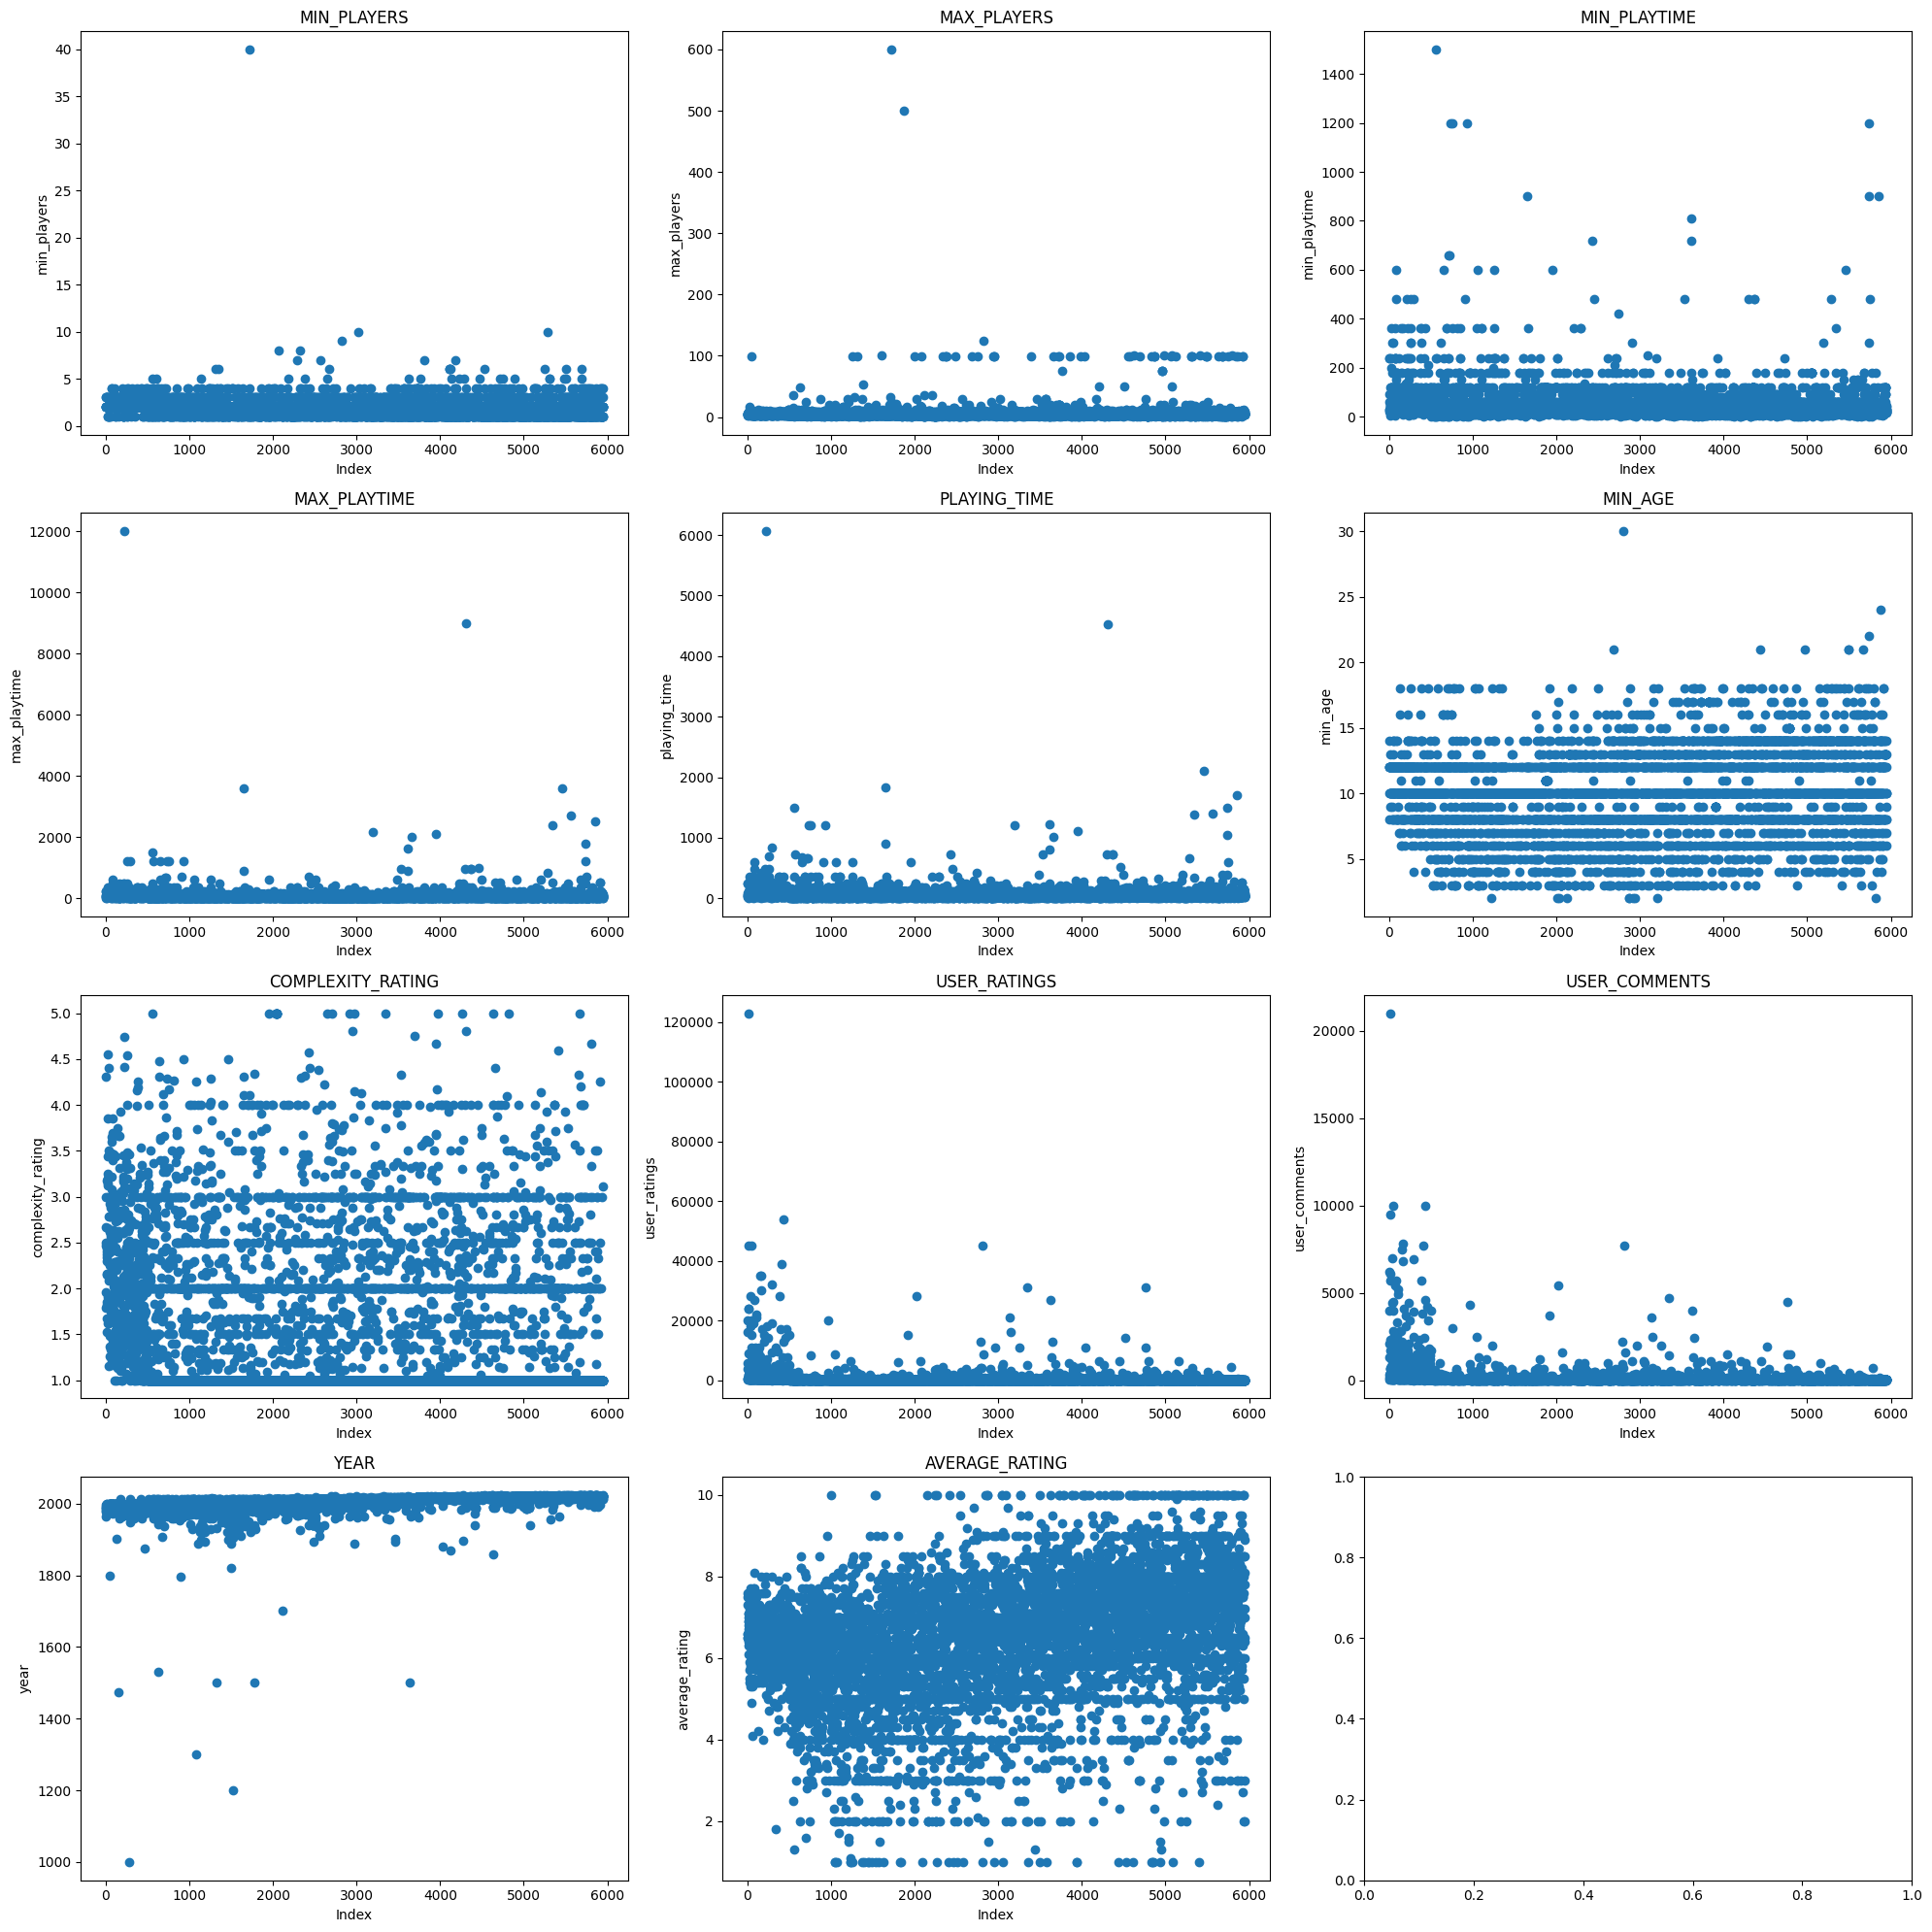

In [63]:
num_cols = raw_df.select_dtypes(exclude=['object', 'bool']).columns
num_rows = math.ceil(len(num_cols) / 3)

fig, ax = plt.subplots(num_rows, 3, figsize=(20, 20))

# If ax is not an array, convert it into a 1D array
if not isinstance(ax, np.ndarray):
    ax = np.array([ax])

for ax, col in zip(ax.flatten(), num_cols):
    ax.scatter(raw_df.index, raw_df[col])
    ax.set_title(str(col).upper())
    ax.set_xlabel('Index')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

In [64]:
# percentile method
raw_df = outlier_detector(raw_df, num_cols, take_care_outliners=True, print_outliners=False, q_1=0.01, q_3=0.99)
outlier_detector(raw_df, num_cols, print_outliners=True, q_1=0.01, q_3=0.99)

,Min,Low_Limit,Mean,Median,Up_Limit,Max,Outlier,Number of Outliers
min_players,1.0,-4.0,2.0,2.0,8.0,8.0,No,0.0
max_players,1.0,-72.0,6.0,4.0,124.0,100.0,No,0.0
min_playtime,1.0,-348.0,46.0,30.0,592.0,720.0,Max,8.0
max_playtime,1.0,-528.0,63.0,45.0,892.0,720.0,No,0.0
playing_time,1.0,-438.0,55.0,38.0,742.0,720.0,No,0.0
min_age,2.0,-20.0,10.0,10.0,40.0,30.0,No,0.0
complexity_rating,1.0,-4.0,2.0,1.0,8.0,5.0,No,0.0
user_ratings,1.0,-7798.0,259.0,10.0,12998.0,21000.0,Max,14.0
user_comments,0.0,-2250.0,76.0,5.0,3750.0,4000.0,Max,4.0
year,1821.0,1817.0,2007.0,2012.0,2145.0,2024.0,No,0.0


In [65]:
print(f"Data shape: {raw_df.shape}")

Data shape: (5879, 20)


<div style="font-size:14px; font-family:Verdana; border-radius:10px; border: #4E5672 solid; padding: 15px; background-color: #CCFFCC; text-align:left; color: #4E5672">


<h3 align="left"><font color='#4E5672'>💡 Comment:</font></h3>

* To gain deeper insights into the boardgame data, we employed a combination of statistical analysis and data visualization techniques. This approach allowed us to identify several data points that deviated significantly from the overall trends and patterns. Specifically, the following columns exhibited the most prominent outliers:
`max_playtime`, `playing_time`, `user_ratings`, `user_comments`, and `year`.

* Given the presence of these outliers, we implemented a percentile-based approach to detect and handle them effectively. This method utilizes percentiles to define thresholds for outlier identification, allowing us to distinguish between genuine outliers and legitimate data points within the normal range. By implementing this outlier detection strategy, we achieved two key benefits:
  
  * **Improved data quality:** Removing outliers from the dataset reduces the potential for bias and distortion in our subsequent analyses.
    
  * **Enhanced performance:** Focusing on non-outlier data points allows for more efficient and accurate analysis, leading to more reliable and insightful conclusions.

</div>

> <span style='font-size:15px; font-family:Arial; color: #87CEFA;'><b>
Dropping "nonsense" features </b></span>

In [66]:
def drop_feature(data, columns, percentage):
    '''Drop features with the same value in all rows
    Args:
        data: dataframe
        columns: list of columns to drop
        percentage: threshold to drop
    Return:
        data: dataframe after dropping
        new_cat_cols: list of columns after dropping
    '''
    new_cat_cols = [col for col in columns if (data[col].value_counts().sort_values(ascending=False) / len(data) * 100).iloc[0] <= percentage]
    dropped_cols = list(set(columns) - set(new_cat_cols))
    if dropped_cols:
        print(f"Dropped features: {', '.join(dropped_cols)}")
    return data, new_cat_cols

In [67]:
raw_df, cat_cols = drop_feature(raw_df, cat_cols, percentage = 90)

<div style="font-size:14px; font-family:Verdana; border-radius:10px; border: #4E5672 solid; padding: 15px; background-color: #CCFFCC; text-align:left; color: #4E5672">


<h3 align="left"><font color='#4E5672'>💡 Comment:</font></h3>

* The purpose of this function; automatically identify and drop categorical features that are considered "nonsense" because they have a dominant value that covers a high percentage of the dataset. The threshold for considering a feature as "nonsense" is controlled by the percentage parameter.
</div>


<a id="1.2"></a>
<h2 style=" font-family: Arial; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #00CC99; padding: 15px;  border-bottom: 2px solid blue;
"><b>Transformating </b> data


> <span style='font-size:15px; font-family:Arial; color: #87CEFA;'><b>
Convert list-like column elements to separate rows </b></span>

<div style="font-size:14px; font-family:Verdana; border-radius:10px; border: #4E5672 solid; padding: 15px; background-color: #CCFFCC; text-align:left; color: #4E5672">


<h3 align="left"><font color='#4E5672'>💡 Comment:</font></h3>

* If you have a list containing nested structures like lists or dictionaries, explode can be used to flatten the structure and access the individual elements.

* This can be helpful for tasks like searching for specific values within the nested structures or performing calculations on the elements.
</div>


In [68]:
def split_and_strip(df, column):
    '''
    Split and strip string in a column
    Args:
        df: dataframe
        column: column name
    Return:
        dataframe after splitting and stripping
    '''
    return df[column].apply(lambda x: [item.strip() for item in str(x).split(',') if not item.strip().startswith('+')])



In [69]:
selected_cols = ['type', 'category', 'mechanism']
for col in selected_cols:
    raw_df[col] = split_and_strip(raw_df, col)

raw_df[selected_cols].head(5)

,type,category,mechanism
0,[Strategy],"[Abstract Strategy, Medieval]","[Area Majority / Influence, Hand Management, H..."
1,[Strategy],"[Economic, Negotiation, Political]","[Alliances, Area Majority / Influence, Auction..."
2,[Strategy],"[Card Game, Fantasy]",[Trick-taking]
3,[Strategy],[Ancient],"[Action Points, Area Majority / Influence, Auc..."
4,[Abstract],"[Abstract Strategy, Children's Game, City Buil...","[Enclosure, Pattern Building, Pattern Recognit..."


In [70]:
raw_df = raw_df.explode('type').explode('category').explode('mechanism')
raw_df.shape

(41927, 20)

> <span style='font-size:15px; font-family:Arial; color: #87CEFA;'><b>
Converting data type </b></span>

In [71]:
raw_df['year'] = raw_df['year'].astype(int)

selected_cols = ['min_players', 'max_players', 'min_playtime', 'max_playtime', 'playing_time', 'min_age']
raw_df[selected_cols] = raw_df[selected_cols].astype('int64')

selected_cols = raw_df.select_dtypes(include=['object', 'bool']).columns.tolist()
raw_df[selected_cols] = raw_df[selected_cols].astype('category')

raw_df.dtypes.reset_index().rename(columns={'index': 'column_name', 0: 'data_type'})

,column_name,data_type
0,name,category
1,description,category
2,designer,category
3,artist,category
4,publisher,category
5,min_players,int64
6,max_players,int64
7,min_playtime,int64
8,max_playtime,int64
9,playing_time,int64


<div style="font-size:14px; font-family:Verdana; border-radius:10px; border: #4E5672 solid; padding: 15px; background-color: #CCFFCC; text-align:left; color: #4E5672">


<h3 align="left"><font color='#4E5672'>💡 Comment:</font></h3>

* To ensure efficient resource utilization and facilitate subsequent processing steps, the extracted data underwent a data type optimization process. This involved converting data types to the most appropriate format, balancing storage efficiency with computational processing needs.

</div>


<a id="1.2"></a>
<h2 style=" font-family: Arial; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #00CC99; padding: 15px;  border-bottom: 2px solid blue;
"><b>Saving </b> data

In [72]:
processed_df = raw_df.copy()
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41927 entries, 0 to 5951
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   name               41927 non-null  category
 1   description        41927 non-null  category
 2   designer           41927 non-null  category
 3   artist             41927 non-null  category
 4   publisher          41927 non-null  category
 5   min_players        41927 non-null  int64   
 6   max_players        41927 non-null  int64   
 7   min_playtime       41927 non-null  int64   
 8   max_playtime       41927 non-null  int64   
 9   playing_time       41927 non-null  int64   
 10  min_age            41927 non-null  int64   
 11  complexity_rating  41927 non-null  float64 
 12  user_ratings       41927 non-null  int64   
 13  user_comments      41927 non-null  int64   
 14  type               41927 non-null  category
 15  category           41927 non-null  category
 16  mechanism 

In [73]:
# Save preprocessed data into csv file
processed_df.to_csv(f"../data/processed/processed_data.csv", index=False)